In [1]:
from util import get_data

lang = "eng"
train = get_data(lang = lang, train=True, clean=False)
dev = get_data(lang = lang, train=False, clean=False)
test = get_data(lang = lang, test=True, clean=False)

train = train[['s1', 's2']]
dev = dev[['s1', 's2']]
test = test[['s1', 's2']]

/home/tollef/git/STS-augmented-pair-encoder/pair_encoder/model.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd

def merge(split1, split2):
    # merge
    split1['label'] = 0
    split2['label'] = 1
    _df = pd.concat([split1, split2])
    # stratified shuffle
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
    for train_index, test_index in sss.split(_df[['s1', 's2']], _df['label']):
        split1 = _df.iloc[train_index]
        split2 = _df.iloc[test_index]

    return split1, split2

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[0.         0.80545455 1.        ] [0.         0.16730769 1.        ] 0.18092657342657342


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[0. 1.] [0. 1.] 0.5


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[0. 1.] [0. 1.] 0.5


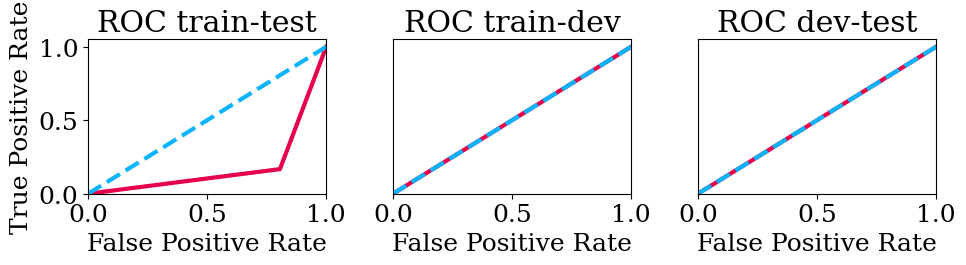

In [3]:
from sentence_transformers import CrossEncoder, InputExample
from sentence_transformers.cross_encoder.evaluation import CESoftmaxAccuracyEvaluator
from torch.utils.data import DataLoader

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from util import palette

plt.rc('font', family='serif')
plt.rc('font', size=18)

def plot_auc(fpr, tpr, roc_auc, lang, ax, title):
    print(fpr, tpr, roc_auc)
    lw = 3
    ax.plot(fpr, tpr, color=palette[0], lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color=palette[1], lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC {title}')
    # ax.legend(loc="lower right")

def make_data(train, test):
    train_examples = []
    dev_examples = []
    for i, row in train.iterrows():
        train_examples.append(InputExample(texts=[row['s1'], row['s2']], label=row['label']))
    for i, row in test.iterrows():
        dev_examples.append(InputExample(texts=[row['s1'], row['s2']], label=row['label']))

    return train_examples, dev_examples

fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharex=True, sharey=True)

axs = axs.flatten()

langs = "ary amh eng tel".split()
langs = "eng mar tel ary".split()
langs = "eng".split()



# for i, lang in enumerate(langs):
split_names = ["train-test", "train-dev", "dev-test"]
for i, splits in enumerate([(train, test), (train, dev), (dev, test)]):
    train, test = merge(splits[0], splits[1])
    train_examples, dev_examples = make_data(train, test)

    train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=32)
    evaluation = CESoftmaxAccuracyEvaluator.from_input_examples(dev_examples, name='adversarial_dev')
    model = CrossEncoder("xlm-roberta-base", num_labels=2)
    epochs = 5
    model.fit(
        train_dataloader=train_dataloader,
        evaluator=evaluation,
        epochs=epochs,
        warmup_steps=len(train_dataloader) * 0.1 * epochs,
        show_progress_bar=False
    )
    model_predictions = model.predict([example.texts for example in dev_examples])
    model_predictions = [1 if pred[0] > pred[1] else 0 for pred in model_predictions]
    fpr, tpr, _ = roc_curve([example.label for example in dev_examples], model_predictions)
    roc_auc = auc(fpr, tpr)
    plot_auc(fpr, tpr, roc_auc, lang=lang, ax=axs[i], title=split_names[i])
    if i != 0:
        axs[i].get_yaxis().set_visible(False)
    
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.tight_layout()
plt.savefig("FIGURES/roc_auc_english.pdf")
plt.show()